In [1]:
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from mosm.multi_spectralmixture import MultiSpectralMixture as MOSM

plt.ion()
sns.set(style='white', color_codes=True)
random = np.random.RandomState(seed=42)

# Multi-Output Spectral Mixture Kernel Example

## Generate input data

Generation of synthetic input data. Feel free to generate/import your own data.

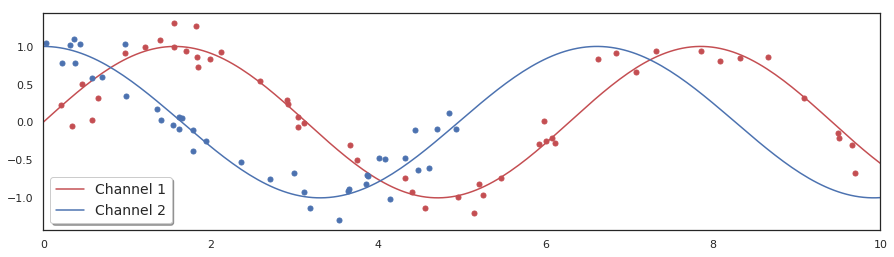

In [2]:
# latent process
N_sample = 200
X_latent = np.linspace(0, 10, N_sample)
f1 = np.sin(X_latent) 
f2 = np.cos(0.95 * X_latent) 

# observations
N1 = 50
N2 = 40
X1_obs = random.uniform(0, 10, N1)
X2_obs = random.uniform(0, 5, N2)
Y1 = np.sin(X1_obs)  + 0.2 * random.randn(N1)
Y2 = np.cos(0.95*X2_obs)  + 0.2 * random.randn(N2)

# plot data
fig = plt.figure(figsize=(15, 4))

ax = fig.gca()
ax.plot(X_latent, f1, 'r-', label='Channel 1')
ax.plot(X_latent, f2, 'b-', label='Channel 2')
ax.plot(X1_obs, Y1, 'r.', ms=10)
ax.plot(X2_obs, Y2, 'b.', ms=10)
ax.set_xlim([X_latent.min(), X_latent.max()])
ax.legend(loc=3,shadow=True, fancybox=True,prop={'size':14})

By adding an extra input dimension for every observation that represents the source channel, multiple outputs can be modeled within gpflow.

In [3]:
# format input data
X_input = np.vstack([np.column_stack([np.zeros_like(Y1), X1_obs]), 
                     np.column_stack([np.ones_like(Y2), X2_obs])])
Y_input = np.hstack([Y1, Y2])[:, None]

# augmented input for prediction
X_pred = np.vstack([np.column_stack([np.zeros_like(X_latent), X_latent]), 
                    np.column_stack([np.ones_like(X_latent), X_latent])]) 

# set data dimensions
INPUT_DIM = 1
N_OUTPUTS = 2

## Create MOSM Kernel

In [4]:
# change the following line to True to set initial values for hyperparameters (not required)
set_initial_values = False

if set_initial_values:
    weights_init = np.ones(N_OUTPUTS)
    means_init   = 0.5 * np.ones(N_OUTPUTS)[None, :]
    var_init     = np.ones(N_OUTPUTS)[None, :]
    delay_init   = np.zeros(N_OUTPUTS)[None, :]
    phase_init   = np.zeros(N_OUTPUTS)
    
    kern = MOSM(INPUT_DIM, N_OUTPUTS, weights_init, means_init, 
                var_init, delay_init, phase_init)

kern = MOSM(INPUT_DIM, N_OUTPUTS)

number_of_components = 1
for i in range(number_of_components - 1):
    kern += MOSM(INPUT_DIM, N_OUTPUTS)

## Create Regression Model

In [5]:
model = gpflow.models.GPR(X_input, Y_input, kern)
model.likelihood.variance = 0.5

In [6]:
model.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/constant,Parameter,None,(none),True,"(2,)",True,"[-1.58288041988055, 1.3601969177318851]"
GPR/kern/delay,Parameter,None,PartiallyFixed,True,"(1, 2)",True,"[[0.0, 0.0]]"
GPR/kern/mean,Parameter,None,(none),True,"(1, 2)",True,"[[1.0, 1.0]]"
GPR/kern/phase,Parameter,None,PartiallyFixed,True,"(2,)",True,"[0.0, 0.0]"
GPR/kern/variance,Parameter,None,+ve,True,"(1, 2)",True,"[[1.0, 1.0]]"
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.5


## Train Model

Training the model, feel free to use any other optimizer

In [7]:
gpflow.train.ScipyOptimizer().minimize(model, disp=True, maxiter=500)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -15.754732
  Number of iterations: 239
  Number of functions evaluations: 306


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -15.754732
  Number of iterations: 239
  Number of functions evaluations: 306


In [8]:
# predict at inputs given by X_pred
Y_pred, STD_pred = model.predict_y(X_pred)  

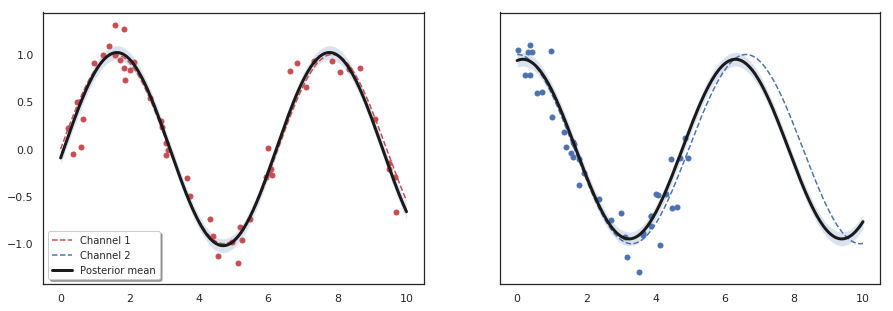

In [8]:
# plot predicions
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)

ch1, = axes[0].plot(X_latent, f1, 'r--', label='Channel 1')
axes[0].plot(X1_obs, Y1, 'r.', ms=10)
pred, = axes[0].plot(X_latent, Y_pred[:N_sample], 'k-', lw=3, label='Posterior mean')
axes[0].fill_between(X_latent, (Y_pred[:N_sample] - 2 * STD_pred[:N_sample]).reshape([-1]), 
                     (Y_pred[:N_sample] + 2 * STD_pred[:N_sample]).reshape([-1]), alpha=0.2) 

ch2, = axes[1].plot(X_latent, f2, 'b--', label='Channel 2')
axes[1].plot(X2_obs, Y2, 'b.', ms=10)
axes[1].plot(X_latent, Y_pred[N_sample:], 'k-', lw=3)
axes[1].fill_between(X_latent, (Y_pred[N_sample:] - 2 * STD_pred[N_sample:]).reshape([-1]), 
                     (Y_pred[N_sample:] + 2 * STD_pred[N_sample:]).reshape([-1]), alpha=0.2) 

axes[0].legend(handles=[ch1, ch2, pred], loc=3, shadow=True, fancybox=True, prop={'size':10})

Print model parameters

In [9]:
model.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/constant,Parameter,None,(none),True,"(2,)",True,"[-14.208368285512087, 13.211147518790183]"
GPR/kern/delay,Parameter,None,PartiallyFixed,True,"(1, 2)",True,"[[0.0, 3.1473808392040525]]"
GPR/kern/mean,Parameter,None,(none),True,"(1, 2)",True,"[[-1.0221555427418378, -1.022154591144741]]"
GPR/kern/phase,Parameter,None,PartiallyFixed,True,"(2,)",True,"[0.0, 4.862842654810794]"
GPR/kern/variance,Parameter,None,+ve,True,"(1, 2)",True,"[[1.0580419948579207e-06, 1.0585151632237007e-..."
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.035772385168979806
